In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# Data analysis and results
Most of the data preprocessing has been effectuated : we have transformed 365 files into 3.6 millions records (correponds to one year) of long-distant train statuses. A delay feature has been added to conduct some analysis.

Some minor last data processing steps are effectuated here, such as transforming delay feature into seconds, to make working with it simple

In [2]:
# Clean data contains every "stop" for a year for the IC, IR and RE trains operated by SBB
data = pd.read_pickle('Data/data_clean_201807-201906.pkl')

In [3]:
# reset index
data = data.reset_index()

In [4]:
# How much data in MB
data.memory_usage().sum()/10e6

49.986614

In [5]:
data.head()

,index,BETRIEBSTAG,LINIEN_TEXT,VERKEHRSMITTEL_TEXT,ZUSATZFAHRT_TF,FAELLT_AUS_TF,HALTESTELLEN_NAME,ANKUNFTSZEIT,AN_PROGNOSE,AN_PROGNOSE_STATUS,ABFAHRTSZEIT,AB_PROGNOSE,AB_PROGNOSE_STATUS,DURCHFAHRT_TF,DELAY_AN,DELAY_AB
0,351,01.07.2018,IC3,IC,True,False,Basel SBB,NaN,NaN,PROGNOSE,01.07.2018 08:07,01.07.2018 08:08:27,REAL,False,NaT,00:01:27
1,352,01.07.2018,IC3,IC,True,False,Zürich HB,01.07.2018 09:04,01.07.2018 09:04:27,REAL,NaN,NaN,PROGNOSE,False,00:00:27,NaT
2,375,01.07.2018,IC,IC,True,False,Lugano,NaN,NaN,PROGNOSE,01.07.2018 16:36,01.07.2018 16:39:48,REAL,False,NaT,00:03:48
3,376,01.07.2018,IC,IC,True,False,Bellinzona,01.07.2018 17:07,01.07.2018 17:05:08,REAL,01.07.2018 17:10,01.07.2018 17:11:00,REAL,False,-1 days +23:58:08,00:01:00
4,377,01.07.2018,IC,IC,True,False,Arth-Goldau,01.07.2018 18:09,01.07.2018 18:09:00,REAL,01.07.2018 18:11,01.07.2018 18:13:00,REAL,False,00:00:00,00:02:00


In [6]:
# Delay information can have several statuses : real, forecasted or unknown.
# for this analysis it was decided to keep them all. We would need to contact the owner of the data to know more about it

In [7]:
data['AN_PROGNOSE_STATUS'].value_counts()

REAL         3496722
PROGNOSE      887247
UNBEKANNT        821
Name: AN_PROGNOSE_STATUS, dtype: int64

In [8]:
data.groupby(['AN_PROGNOSE_STATUS','VERKEHRSMITTEL_TEXT']).size()/len(data)*100

AN_PROGNOSE_STATUS  VERKEHRSMITTEL_TEXT
PROGNOSE            IC                      5.075089
                    IR                      6.122460
                    RE                      9.037103
REAL                IC                     20.234310
                    IR                     31.042239
                    RE                     28.470075
UNBEKANNT           IC                      0.005109
                    IR                      0.002007
                    RE                      0.011608
dtype: float64

In [9]:
# Get arrival and departure delay in seconds
data['DELAY_DEP_SEC'] = data['DELAY_AB'].dt.total_seconds()
data['DELAY_ARR_SEC'] = data['DELAY_AN'].dt.total_seconds()

In [10]:
data['DURCHFAHRT_TF'].value_counts()

False    4384432
True         358
Name: DURCHFAHRT_TF, dtype: int64

In [11]:
# Trains stops - Percentage by Haltestelle
data['FAELLT_AUS_TF'].value_counts(1)*100

False    96.644537
True      3.355463
Name: FAELLT_AUS_TF, dtype: float64

In [12]:
# Trains stops - Percentage by Haltestelle
haltestelle_frequency = data['HALTESTELLEN_NAME'].value_counts(1)*100

In [13]:
# Trains that are late < 3 minutes - Percentage by Haltestelle
data['HALTESTELLEN_NAME'][data['DELAY_ARR_SEC']>180].value_counts(1)*100

Zürich HB                         4.592584
Olten                             4.183356
Bern                              3.819032
Basel SBB                         2.355865
Lausanne                          2.294378
Spiez                             2.162732
Genève                            2.012461
Morges                            1.751208
Thun                              1.722123
Visp                              1.698907
Solothurn                         1.671608
Nyon                              1.642268
Aarau                             1.548125
Yverdon-les-Bains                 1.452452
Liestal                           1.414948
Vevey                             1.355758
Zürich Flughafen                  1.305752
Aigle                             1.264421
Sion                              1.223090
Brig                              1.203956
Biel/Bienne                       1.203956
Winterthur                        1.202170
Baden                             1.186862
Gland      

In [14]:
# Transform columns into python datetime to be able to use time function on these (such as dt.weekday, etc)
data['ABFAHRTSZEIT'] = pd.to_datetime(data['ABFAHRTSZEIT'],format="%d.%m.%Y %H:%M")
data['ANKUNFTSZEIT'] = pd.to_datetime(data['ANKUNFTSZEIT'],format="%d.%m.%Y %H:%M")
data['BETRIEBSTAG'] = pd.to_datetime(data['BETRIEBSTAG'],format="%d.%m.%Y")

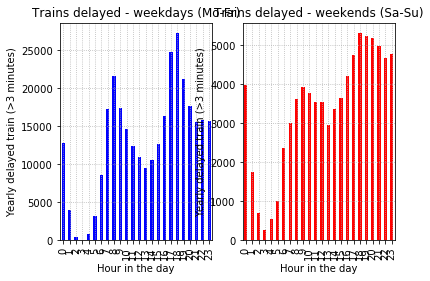

In [15]:
# Trains that are late < 3 minutes - Absolut number by hour
plt.subplot(1,2,1)
ax1 = data['ANKUNFTSZEIT'][(data['DELAY_ARR_SEC']>180) & (data['BETRIEBSTAG'].dt.weekday.isin([0,1,2,3,4]))].dt.hour.value_counts().sort_index().plot(kind='bar',color='blue')
ax1.grid(linestyle=':')
ax1.set(xlabel='Hour in the day',title='Trains delayed - weekdays (Mo-Fr)',ylabel='Yearly delayed train (>3 minutes)')

plt.subplot(1,2,2)
ax1 = data['ANKUNFTSZEIT'][(data['DELAY_ARR_SEC']>180) & (data['BETRIEBSTAG'].dt.weekday.isin([5,6]))].dt.hour.value_counts().sort_index().plot(kind='bar',color='red')
ax1.grid(linestyle=':')
ax1.set(xlabel='Hour in the day',title='Trains delayed - weekends (Sa-Su)',ylabel='Yearly delayed train (>3 minutes)')

plt.rcParams["figure.figsize"] = (14, 4)

## Comment : Train delays in absolut numbers - time analysis
As we can see most of the trains are delayed during the morning and evening rush of the commuters. Weekends also have some peak but are much less pronounced and it seems that both peaks are slightly shifted to a later time.

In [16]:
# Trains that are late < 3 minutes - Number by date
hour_nbtrainslate = data['BETRIEBSTAG'][data['DELAY_ARR_SEC']>180].dt.date.value_counts().sort_index()

# Trains - Number by date
hour_nbtrains = data['BETRIEBSTAG'].dt.date.value_counts().sort_index()

In [17]:
perc_trainslate = hour_nbtrainslate/hour_nbtrains*100

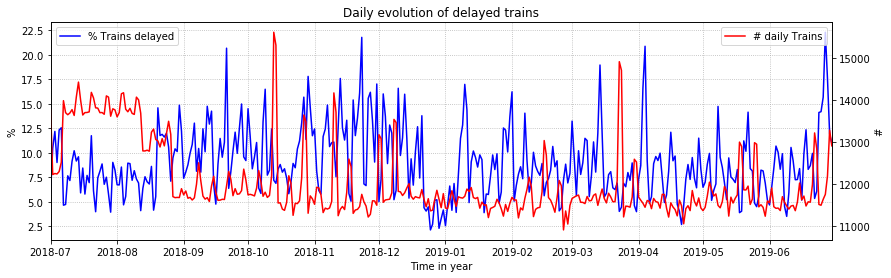

In [18]:
# Trains late by day - percentage and absolute number
ax1 = (perc_trainslate).plot(label='% Trains delayed',color='blue')
ax2 = hour_nbtrains.plot(secondary_y=True,color='red',label='# daily Trains',ax=ax1)
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
ax1.grid(linestyle=':')
ax1.set(xlabel='Time in year',ylabel='%', title='Daily evolution of delayed trains')
ax2.set(ylabel='#')
plt.rcParams["figure.figsize"] = (20, 4)

## Comment : train delays in percentage - evolution over the year
We can clearly observe a weekly pattern in the percentage of delayed trains. Periods of holidays and weekends have a lower rate of delays, eventhough the frequency of trains is even increased in some cases, such has during the school summer holidays (July to mid-August).

In [19]:
# Quick look at the top 10 days with most delays in percentage
print(perc_trainslate.sort_values(ascending=False).head(10))

2019-06-27    22.303567
2018-11-23    21.782431
2019-04-04    20.874126
2018-09-21    20.677824
2019-03-14    18.961683
2018-10-29    17.801186
2018-11-13    17.591292
2019-06-28    17.569342
2018-11-30    17.026462
2019-01-10    16.988549
Name: BETRIEBSTAG, dtype: float64


## Comment : top 10 days with most delays
Conducting a deeper analysis on trying to find out the root causes for these peaks would be very interesting.
I personally remember the 27 and 28th of June were many people described as "chaotic" the situation to get back home after work with the rail. In fact, a heat wave was happening in Switzerland and from observation I would tend to say that there is a correlation between high temperatures and delays. Crossing validating this statement with weather dataset would be very interesting.

(-150, 3000)

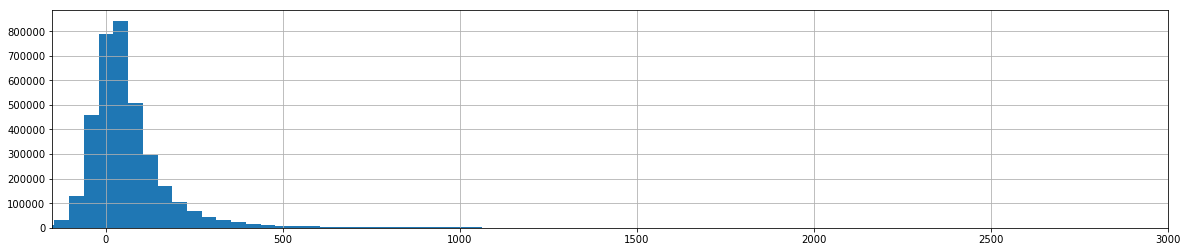

In [20]:
# Distribution of time delays (can be negative when trains arrive before scheduled time)
ax = data['DELAY_ARR_SEC'].hist(bins=600)
ax.set_xlim((-150,3000))

In [21]:
# Take top 20 stations by frequency
top20_stops = haltestelle_frequency[0:20].index
data_delays = pd.DataFrame(data[['HALTESTELLEN_NAME','DELAY_ARR_SEC']][data['HALTESTELLEN_NAME'].isin(top20_stops)])
data_delays['HALTESTELLEN_NAME'].unique()

array(['Basel SBB', 'Zürich HB', 'Luzern', 'Olten', 'Brig', 'Bern',
       'Baden', 'Brugg AG', 'Biel/Bienne', 'Lausanne', 'St. Gallen',
       'Zürich Flughafen', 'Winterthur', 'Morges', 'Genève',
       'Genève-Aéroport', 'Vevey', 'Nyon', 'Zürich Oerlikon', 'Aarau'], dtype=object)

In [22]:
# Plot frequency of each train station
ax1 = (data_delays.groupby('HALTESTELLEN_NAME').count()/365)['all'].sort_values(ascending=False).plot(kind='bar', label='')
ax1.axis('tight')
ax1.grid(linestyle=':')
ax2.legend(['# train stops'],loc='lower right')
ax1.set(ylabel='avg number of trains/day',xlabel='Top 20 train stations')
ax2.set_ylabel('total in tousands/year')

plt.title('Train station frequency')
plt.rcParams["figure.figsize"] = (12, 4)

KeyError: 'all'

## Comment : train station frequency : 
Zurich main station is by far the mostly frequented station in Switzerland.

In [ ]:
# data_delays contains delay time on arrival in seconds. Group delays by delays in minutes, as following : 
min_to_sec = 60
data_delays['all'] = 1
data_delays['03-05min'] = (data_delays['DELAY_ARR_SEC']>=3*min_to_sec) & (data_delays['DELAY_ARR_SEC']<5*min_to_sec)
data_delays['05-07min'] = (data_delays['DELAY_ARR_SEC']>=5*min_to_sec) & (data_delays['DELAY_ARR_SEC']<7*min_to_sec)
data_delays['07-10min'] = (data_delays['DELAY_ARR_SEC']>=7*min_to_sec) & (data_delays['DELAY_ARR_SEC']<10*min_to_sec)
data_delays['10-15min'] = (data_delays['DELAY_ARR_SEC']>=10*min_to_sec) & (data_delays['DELAY_ARR_SEC']<15*min_to_sec)
data_delays['15-20min'] = (data_delays['DELAY_ARR_SEC']>=15*min_to_sec) & (data_delays['DELAY_ARR_SEC']<20*min_to_sec)
data_delays['>20min'] = (data_delays['DELAY_ARR_SEC']>=20*min_to_sec)

In [ ]:
data_delays.columns

In [ ]:
df_pivot = pd.pivot_table(data_delays, index=['HALTESTELLEN_NAME'],values=['all','03-05min', '05-07min',
       '07-10min', '10-15min', '15-20min', '>20min'], aggfunc=np.sum)

In [ ]:
# pivot data_delays to have as index the name of the top 20 stations
df_pivot = pd.pivot_table(data_delays, index=['HALTESTELLEN_NAME'],values=['all','03-05min', '05-07min',
       '07-10min', '10-15min', '15-20min', '>20min'], aggfunc=np.sum)
print(df_pivot.head())
# Transform df_pivot to have percentage instead in every column
df_pivot_perc = df_pivot.divide(df_pivot['all'],axis=0)*100
df_pivot_perc['>3min'] = df_pivot_perc.sum(axis=1)
df_pivot_perc = df_pivot_perc.sort_values(by='>3min', ascending=False)
df_pivot_perc = df_pivot_perc.drop(labels=['>3min'],axis=1)

In [ ]:
# pivot data_delays to have as index the name of the top 20 stations
df_pivot = pd.pivot_table(data_delays, index=['HALTESTELLEN_NAME'],values=['all','03-05min', '05-07min',
       '07-10min', '10-15min', '15-20min', '>20min'], aggfunc=np.sum)
print(df_pivot.head())

In [ ]:
# Transform df_pivot to have percentage instead in every column
df_pivot_perc = df_pivot.divide(df_pivot['all'],axis=0)*100
df_pivot_perc['>3min'] = df_pivot_perc.sum(axis=1)
df_pivot_perc = df_pivot_perc.sort_values(by='>3min', ascending=False)
df_pivot_perc = df_pivot_perc.drop(labels=['>3min'],axis=1)
# Remove "all" column, which contains the total number of trains per year for each station
df_pivot_perc = df_pivot_perc.drop(labels='all',axis=1)
df_pivot_perc['total'] = df_pivot['all']
print(df_pivot_perc.head())

In [ ]:
ax1 = df_pivot_perc.drop(labels=['total'],axis=1).plot(kind='bar',stacked=True)
ax2 = (df_pivot_perc['total']/365).plot(color= 'red',ax=ax1, secondary_y=True)
ax1.axis('tight')
ax1.grid(linestyle=':')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.legend(loc='upper right')
ax2.legend(['# train stops'],loc='lower right')
ax1.set(ylabel='% of trains delayed',xlabel='Top 20 train stations (by frequency)')
ax2.set_ylabel('total in tousands/year')

plt.title('Delayed trains by stations')
plt.rcParams["figure.figsize"] = (12, 4)

## Comment - most delayed train stations
Bern and Olten are the two stations mostly affected by delays. There are two important nodes of the swiss rail ways system. Nodes in the sense that tracks go several directions.

In [ ]:
# Table with delays, sorted by total number of trains
df_pivot_perc.sort_values(by='total',ascending=False)

## Results conclusion and outlook
Very interesting insights from the train delays and frequency could be taken out from this dataset. I would suggest anyone who is interested in the topic to continue digging to expand further this analysis that deserves more investigation.